###### Dimensionality Reduction Starter Coder 
# Version 6 includes TFIDF Cosine Similarity Starter Code
# Doc2Vec and Word2Vec
# TSNE visualization and K-Means document listings are provided to help you perform analysis
## 2021WI_MSDS_453-DL_SEC56
### jennifer.sleeman@northwestern.edu, paulhuynh2018@u.northwestern.edu



In [1]:
pip install rake-nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=26663822a9616786ca029da6060bc8bcb62e79072d9e675dbfeae287bc1ca1f4
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [4]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
import gensim




In [5]:
pip install phrasemachine

In [6]:
#################################################################################
#An Example of One-hot encoding  
#Very Simple Based on example in Deep Learning for Natural Language Processing
#################################################################################
# define example
data = ['ginsburg', 'RBG', 'justice', 'ginsburg']
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

['ginsburg' 'RBG' 'justice' 'ginsburg']
[1 0 2 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
['ginsburg']


In [7]:
# Only run this once, they will be downloaded.
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [9]:
# Pre-process dataset to remove punctuation
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

In [10]:
# Pre-process dataset to lower case it
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

In [11]:
# Pre-process dataset to remove tags
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text

In [12]:
# Pre-process dataset to remove special characters and digits
def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text


In [13]:
# Pre-process dataset to appy Stemming
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

In [14]:
# Pre-process dataset to apply Lemmatization
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [15]:
# Remove stop words
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return filtered_sentence

In [16]:
# Run Phase Machine
def run_phrase_machine(in_text):
    phrases=phrasemachine.get_phrases(in_text)
    return phrases

In [17]:
#Run Rake Keyword Extractor
def run_rake(in_text):
    r = Rake()
    r.extract_keywords_from_text(in_text)
    rake_phrases= r.get_ranked_phrases()
    return rake_phrases

In [18]:
# Run NLTK Tokenizer
def run_nltk_tokenizer(in_text):
    tokens=nltk.word_tokenize(in_text)
    return tokens

In [19]:
# Run NLTK Sentence Tokenizer
def run_nltk_sent_tokenizer(in_corpus):
    sents = nltk.sent_tokenize(in_corpus)
    return sents

In [20]:
#Run word-ngram Tokenizer
def run_nltk_tokenizer_word_ngrams(in_text, ngram_size):
    n_grams = ngrams(nltk.word_tokenize(in_text), ngram_size)
    return [ ' '.join(grams) for grams in n_grams]

In [21]:
#Get Frequ Dist 
def get_freq_dist(terms):
    all_counts = dict()
    all_counts[size] = FreqDist(terms)
    return all_counts

In [22]:

###############################################################################
### Processing text into lists
###############################################################################
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    return (docids,titles,text_body)

In [23]:
import matplotlib.pyplot as plt

In [24]:
###############################################################################
### Functions to visualize documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    return tokens

def process_corpus(data):
        
    #create empty list to store text documents titles
    titles=[]
    
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        temp_text=data['DSI_Title'].iloc[i]
        titles.append(temp_text)
    
    #create empty list to store text documents
    text_body=[]
    
    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    
    #Note: the text_body is the unprocessed list of documents read directly form 
    #the csv.
        
    #empty list to store processed documents
    processed_text=[]
    #for loop to process the text to the processed_text list
    for i in text_body:
        text=clean_doc(i)
        processed_text.append(text)
    
    #Note: the processed_text is the PROCESSED list of documents read directly form 
    #the csv.  Note the list of words is separated by commas.
    
    
    #stitch back together individual words to reform body of text
    final_processed_text=[]
    
    for i in processed_text:
        temp_DSI=i[0]
        for k in range(1,len(i)):
            temp_DSI=temp_DSI+' '+i[k]
        final_processed_text.append(temp_DSI)
    
    return titles, final_processed_text, processed_text

def run_doc2vec(final_processed_text, processed_text):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=1000, window=2, min_count=1, workers=4)    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

def run_word2vec(processed_text):

    #word to vec model
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)
    
    labels = []
    tokens = []

    for word in model_w2v.wv.vocab:
        tokens.append(model_w2v[word])
        labels.append(word)
    
    
    return labels, tokens, model_w2v





def plot_doc2vec(doc2vec_df, titles, perplexity = 2):
    #visualize documents through applying TSNE to doc2vec matrix
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)

    doc2vec_df = tsne_model.fit_transform(doc2vec_df)
    x = []
    y = []
    for value in doc2vec_df:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(titles[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

def plot_word2vec(model, labels, tokens):
    "Creates and TSNE model and plots it"
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(40, 40)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [25]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 13.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.1.0-py2.py3-none-any.whl size=136708 sha256=1291df1b571ea37afd59a70287bb0e755a8109ae1ea84fb9b4ff03c193b13efc
  Stored in directory: /root/.cache/pip/wheels/d1/e7/d3/8f4efa7ff8817ca49a11b1271f9fb40ba9774a56d11342db65
Successfully built pyLDAvis


In [26]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim import similarities


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel
import seaborn as sns

import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import pickle 

import warnings
warnings.filterwarnings('ignore')
# Visualize the topics
pyLDAvis.enable_notebook()

In [27]:
#Section 1: Latent Semantic Analysis Using Gensim's implementation
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

In [63]:
#Section 1: Latent Semantic Analysis Example
def lsa(tfidf_matrix, n_components = 42):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=42)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

In [67]:
lsa(tfidf_matrix, n_components = 42)

Topic 0: 
external
links
about
movie
disney
which
their
Topic 1: 
external
links
spotlight
boston
slave
water
inarritu
Topic 2: 
washington
october
captain
hackman
games
jones
clancy
Topic 3: 
edward
robot
paris
allen
india
robots
intelligence
Topic 4: 
paris
allen
allens
amlie
barcelona
around
woody
Topic 5: 
edward
carter
stone
bucket
cancer
private
nothing
Topic 6: 
eastwood
president
force
presidential
india
malkovich
fugitive
Topic 7: 
captain
india
computer
hackman
october
soviet
submarine
Topic 8: 
india
family
wanted
games
herself
turing
never
Topic 9: 
computer
matrix
schwarzenegger
extremely
reeves
terminator
films
Topic 10: 
moment
blood
glass
assange
daniel
tries
wikileaks
Topic 11: 
walter
photo
schwarzenegger
terminator
matrix
cameron
alice
Topic 12: 
robot
eastwood
walter
captain
photo
presidential
spooner
Topic 13: 
alice
india
moment
matrix
extremely
reeves
assange
Topic 14: 
turing
enigma
schwarzenegger
bletchley
imitation
eastwood
cameron
Topic 15: 
schwarzenegger
ea

In [29]:
#Section 2: Latent Dirichlet Allocation
def lda(tfidf_matrix, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

In [30]:
#Section 3: Word2Vec Matrix Generation
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
###############################################################################
### Setup path to file, get the corpus, set up 
###############################################################################
path_to_file=('/content/drive/MyDrive/movie_reviews/2021_Winter_453_Sec56_Class_Corpus_Updated.csv')
docids,titles,text=get_corpus(path_to_file)
print(titles)

['KS_Doc1_2001 Space Odyssey.txt', 'KS_Doc2_Wargames.txt', 'KS_Doc3_The_Matrix.txt', 'KS_Doc4_I_Robot.txt', 'KS_Doc5_Ex_Machina.txt', 'KS_Doc6_Her.txt', 'KS_Doc7_The Terminator.txt', 'PP_Doc1_Disneys_New_Mulan.txt', 'PP_Doc2_Cinderella_Review_Straight-Faced.txt', 'PP_Doc3_Aladdin_Review_This.txt', 'PP_Doc4_Review_Beauty_And.txt', 'PP_Doc5_Film_Review_Tim.txt', 'PP_Doc6_The_Jungle_Book.txt', 'PP_Doc7_Whats_A_Nice.txt', 'SW_DOC1_AIRFORCEONE.txt', 'SW_DOC2_CLEARANDPRESENTDANGER.txt', 'SW_DOC3_CRIMSONTIDE.txt', 'SW_DOC4_HUNTFORREDOCTOBER.txt', 'SW_DOC5_INTHELINEOFFIRE.txt', 'SW_DOC6_PATRIOTGAMES.txt', 'SW_DOC7_FUGITIVE.txt', 'VPD_DOC1_AMELIE.txt', 'VPD_DOC2_EAT_PRAY_LOVE.txt', 'VPD_DOC3_MIDNIGHT_IN_PARIS.txt', 'VPD_DOC4_THE_BEST_EXOTIC_MARIGOLD_HOTEL.txt', 'VPD_DOC5_THE_SECRET_LIFE_OF_WALTER_MITTY.txt', 'VPD_DOC6_THE_BUCKET_LIST.txt', 'VPD_DOC7_TO_ROME_WITH_LOVE.txt', 'YF_Doc1_Hidden_Figures.txt', 'YF_Doc2_The_Imitation_Game.txt', 'YF_Doc3_Argo.txt', 'YF_Doc4_Snowden.txt', 'YF_Doc5_The_Rev

In [33]:
###############################################################################
### Calculates TFIDF and Saves TFIDF values for terms to a file
###############################################################################
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(text)
transformed_documents_as_array = transformed_documents.toarray()

#CHANGE THIS PATH TO YOUR OWN
output_filenames ="tf_idf_output"

for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(output_filenames+"_"+str(titles[counter]))

In [34]:
###############################################################################
### Calculates the Cosine Similarity across your corpus
###############################################################################
doc_term_matrix = transformed_documents.todense()
df = pd.DataFrame(doc_term_matrix, 
                      columns=vectorizer.get_feature_names(), 
                      index=docids)
   
print(cosine_similarity(df, df))

[[1.         0.05422149 0.03800689 ... 0.04551833 0.0227094  0.00924681]
 [0.05422149 1.         0.04107573 ... 0.03725507 0.02278297 0.00968259]
 [0.03800689 0.04107573 1.         ... 0.02627188 0.02624978 0.01969245]
 ...
 [0.04551833 0.03725507 0.02627188 ... 1.         0.18221265 0.14105931]
 [0.0227094  0.02278297 0.02624978 ... 0.18221265 1.         0.28621993]
 [0.00924681 0.00968259 0.01969245 ... 0.14105931 0.28621993 1.        ]]


In [35]:
#load class corpus
data=pd.read_csv(('/content/drive/MyDrive/movie_reviews/2021_Winter_453_Sec56_Class_Corpus_Updated.csv'))

In [36]:
# =============================================================================
# Running functions to (1): process documents, (2) create doc2vec matrix, and
# (3)plotting with TSNE
# =============================================================================
#process documents
titles, final_processed_text, processed_text = process_corpus(data)

doc2vec_df = run_doc2vec(final_processed_text, processed_text)

labels, tokens, word2vec_model = run_word2vec(processed_text)

In [37]:
print(df.shape[0] * df.shape[1]) #original raw dataset size

238728


In [38]:
print(doc2vec_df.shape[0] * doc2vec_df.shape[1]) #final processed dataset size

42000


In [39]:
def save_list(lines, filename):
# convert lines to a single blob of text
  data = ','.join(map(str, lines))
# open file
  file = open(filename, 'w')
# write text
  file.write(data)
# close file
  file.close()

save_list(processed_text, 'keywords.txt')
save_list(text, 'rawtext.txt')

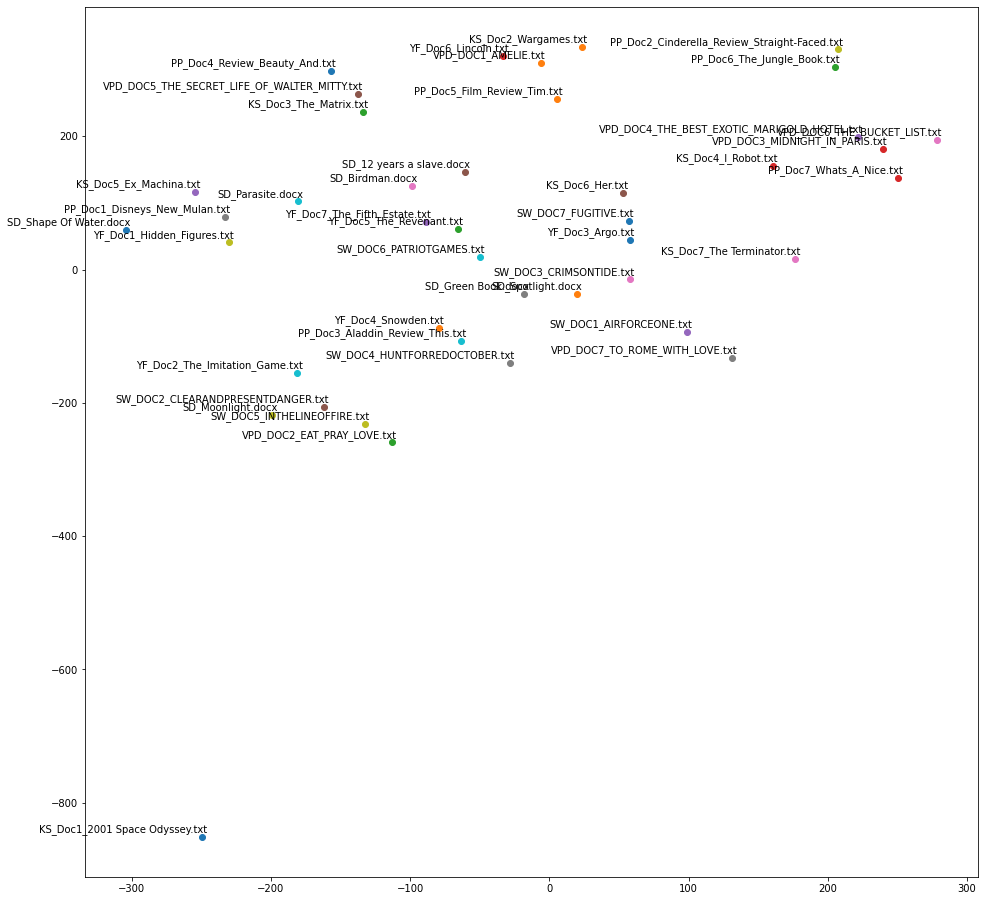

In [40]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_df, titles)

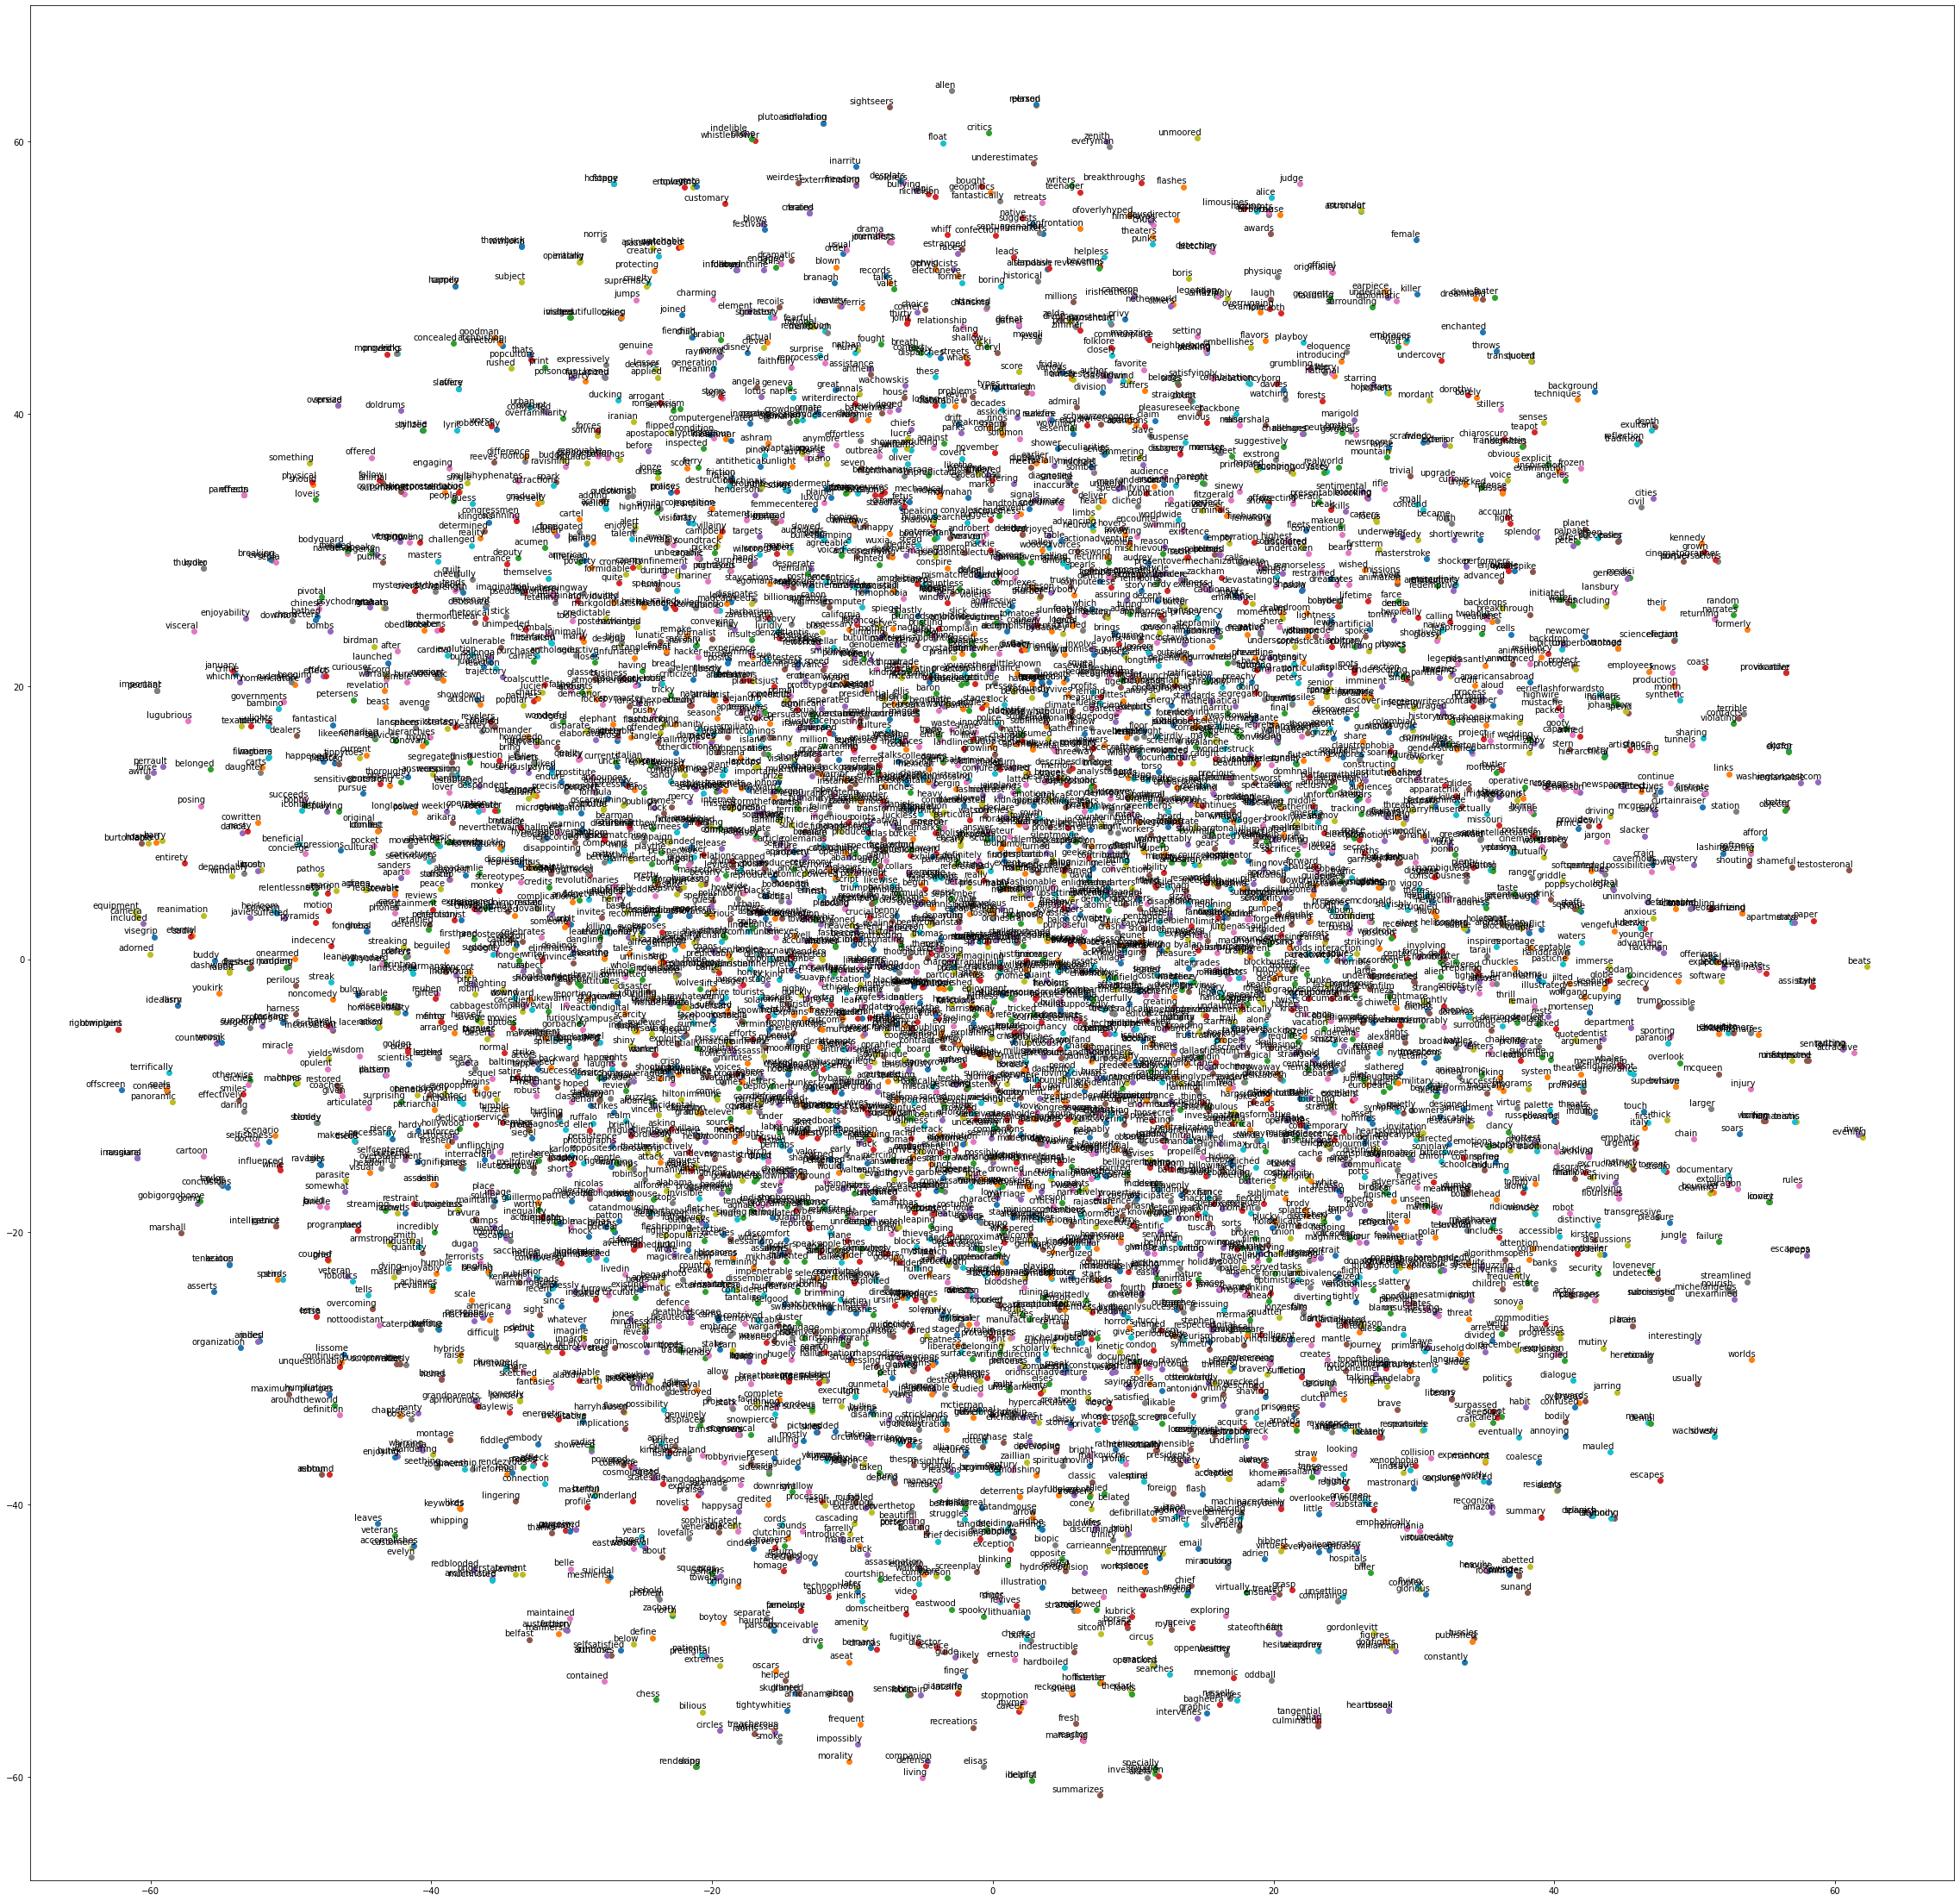

In [41]:
#plot word2vec via TSNE
plot_word2vec(word2vec_model, labels, tokens)

In [42]:
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats, mark_negation

In [43]:
import nltk.sentiment.util as nst

In [44]:
print (nst.mark_negation("I like the movie .".split()))       # ['I', 'like', 'the', 'movie.']
print (nst.mark_negation("I don't like the movie .".split()))  # ['I', "don't", 'like_NEG', 'the_NEG', 'movie._NEG']

['I', 'like', 'the', 'movie', '.']
['I', "don't", 'like_NEG', 'the_NEG', 'movie_NEG', '.']


In [45]:
analyzer = SentimentAnalyzer()
vocabulary = analyzer.all_words([nst.mark_negation(processed_text)])
print ("Vocabulary: ", len(vocabulary)) # 42

Vocabulary:  42


In [46]:
#############################################
#Explore K-means clustering of tfidf matrix
#############################################

#############################################
#Calculates tf idf
#Edit ngram range if you like
#############################################
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=5):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :50]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
        

#############################################
# Run the code
#############################################
tfidf_matrix, terms = tfidf(final_processed_text, titles)
k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=5)

Top terms per cluster:
Cluster 0:
 computer
 robot
 movie
 india
 about
 human
 robots
 edward
 intelligence
 history
 their
 story
 played
 characters
 computers
 space
 future
 turing
 where
 matrix
 allen
 spooner
 script
 might
 which
 another
 there
 around
 stone
 enough
 schwarzenegger
 world
 takes
 young
 enigma
 white
 people
 other
 terminator
 extremely
 reeves
 whose
 after
 viewer
 something
 movies
 certain
 knows
 artificial
 scifi
Cluster 0 titles: KS_Doc1_2001 Space Odyssey.txt, KS_Doc2_Wargames.txt, KS_Doc3_The_Matrix.txt, KS_Doc4_I_Robot.txt, KS_Doc5_Ex_Machina.txt, KS_Doc6_Her.txt, KS_Doc7_The Terminator.txt, VPD_DOC4_THE_BEST_EXOTIC_MARIGOLD_HOTEL.txt, VPD_DOC7_TO_ROME_WITH_LOVE.txt, YF_Doc1_Hidden_Figures.txt, YF_Doc2_The_Imitation_Game.txt, YF_Doc3_Argo.txt, YF_Doc4_Snowden.txt, YF_Doc6_Lincoln.txt,Cluster 1:
 links
 external
 spotlight
 family
 boston
 chiron
 about
 friend
 inarritu
 years
 first
 tutor
 slave
 water
 director
 character
 church
 three
 those


[(0, '0.311*"links" + 0.311*"external" + 0.302*"movie" + 0.249*"about" + 0.164*"which" + 0.157*"their" + 0.137*"story" + 0.125*"first" + 0.117*"while" + 0.102*"other" + 0.097*"there" + 0.095*"after" + 0.093*"through" + 0.092*"those" + 0.091*"disney" + 0.090*"spotlight" + 0.088*"years" + 0.084*"movies" + 0.076*"where" + 0.075*"played" + 0.073*"world" + 0.072*"being" + 0.072*"every" + 0.069*"would" + 0.069*"little" + 0.067*"around" + 0.066*"character" + 0.065*"title" + 0.063*"computer" + 0.063*"could" + 0.062*"things" + 0.060*"comes" + 0.059*"review" + 0.059*"director" + 0.059*"human" + 0.059*"washington" + 0.057*"makes" + 0.057*"himself" + 0.057*"something" + 0.056*"scene" + 0.056*"characters" + 0.056*"october" + 0.055*"between" + 0.054*"family" + 0.054*"before" + 0.053*"place" + 0.053*"captain" + 0.053*"boston" + 0.053*"young" + 0.052*"takes" + 0.052*"michael" + 0.051*"feels" + 0.051*"edward" + 0.050*"three" + 0.050*"these" + 0.050*"another" + 0.050*"seems" + 0.049*"point" + 0.049*"sti

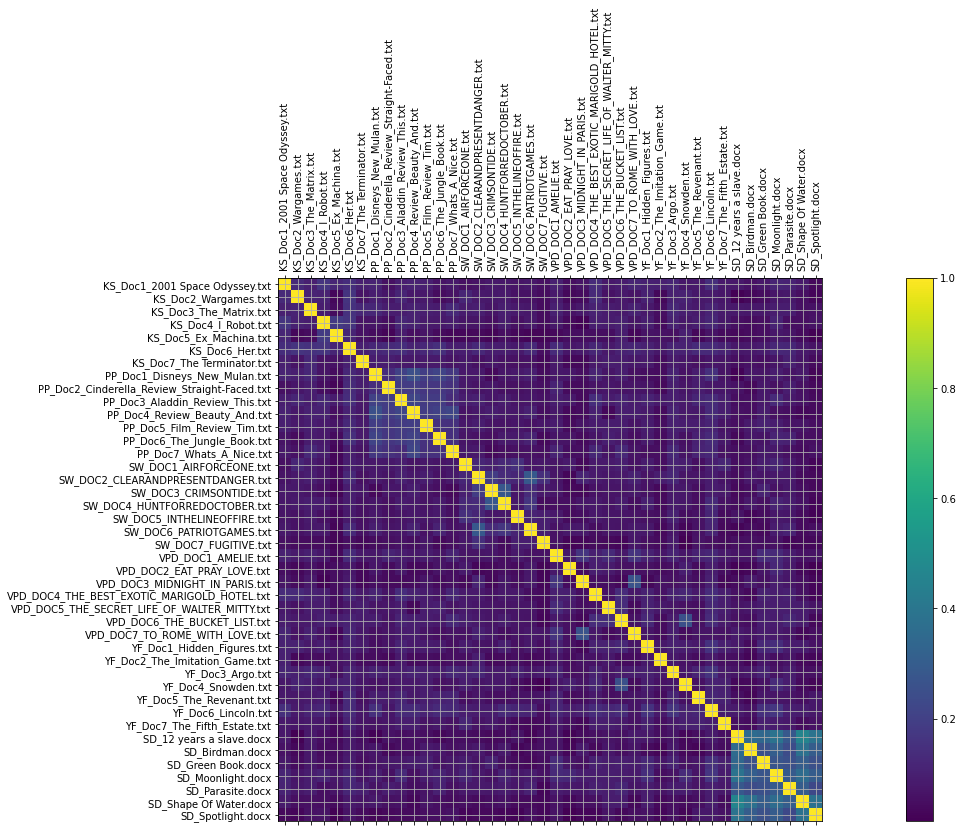

In [64]:
#run section 1
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=42
words=1000
#####################################

model,dictionary,index=create_gensim_lsa_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow = dictionary.doc2bow(doc)
    vec_lsi = model[vec_bow]  # convert the query to LSI space
    sims = index[vec_lsi] # perform a similarity query against the corpus

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

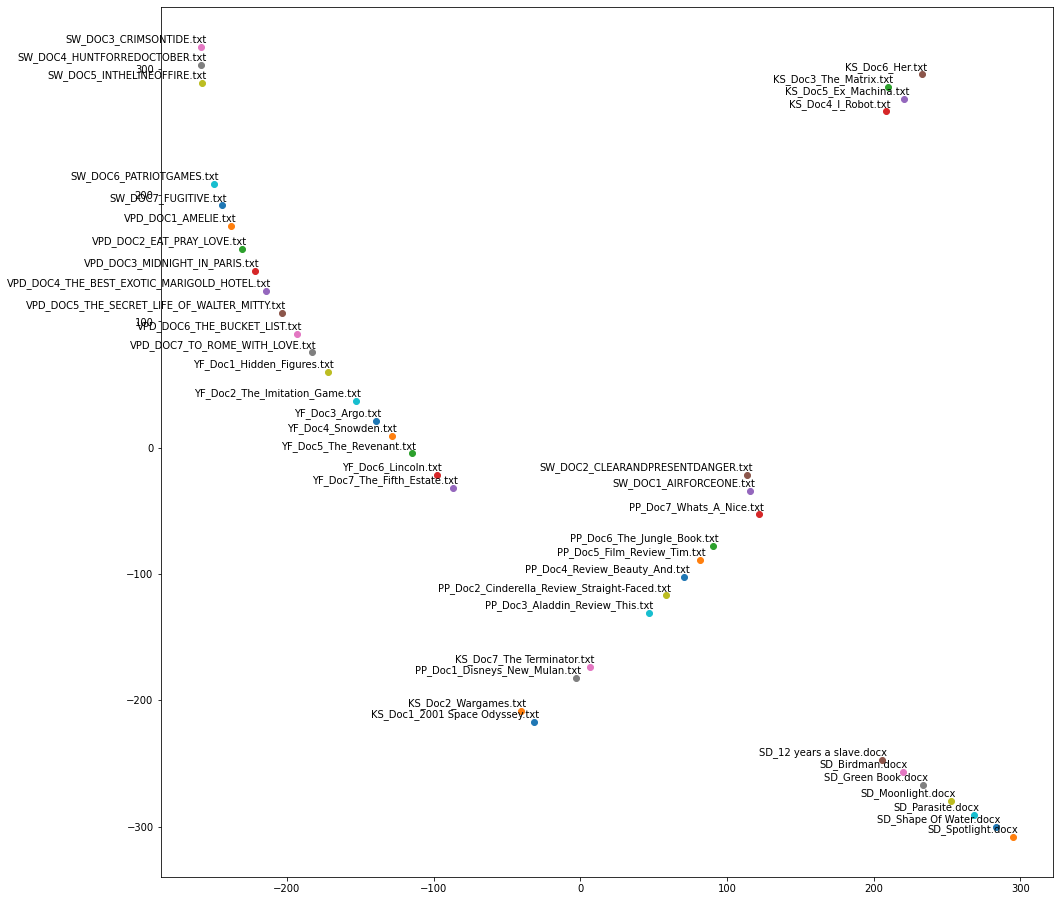

In [65]:
plot_doc2vec(vec_lsi, titles)

In [48]:
#Section 2:  Latent Dirichlet Allocation Using Gensim's implementation
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])



    return ldamodel,dictionary,index,doc_term_matrix

In [49]:
LDAvis_prepared = pyLDAvis.gensim.prepare(model2, doctermmatrix2, dictionary2)
LDAvis_prepared

NameError: ignored

In [ ]:
#run section 2
# Compare this implementation of lda with the gensim
# Any differences in behavior?
number_of_topics=50
words=10

lda(tfidf_matrix, topics = number_of_topics, num_words = 10)

In [ ]:
#run section 3
word2vec_run=word2vec(processed_text, size = 100)

In [ ]:
plot_word2vec(word2vec_run, labels, tokens)

In [ ]:
#run section 2
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=50
words=10
#####################################
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [ ]:
#plot LDA model via TSNE
lda_model=create_gensim_lda_model( processed_text,number_of_topics,words)
plot_word2vec(lda_model,titles, index2)

In [ ]:
#############################################
#Explore K-means clustering of doc2vec matrix
#############################################
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 100):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_doc2vec(doc2vec_model, final_processed_text,titles, k = 5)

In [ ]:
doc2vec_model=doc2vec_model.drop('title', axis=1)

In [ ]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_model, titles)

In [ ]:
plot_doc2vec(tfidf_matrix, titles)